## Run this notebook

You can launch this notebook using mybinder, by clicking the button below.

<a href="https://mybinder.org/v2/gh/US-GHG-Center/ghgc-docs/HEAD?labpath=user_data_notebooks/fossil_fuel_co2_emissions.ipynb">
<img src="https://mybinder.org/badge_logo.svg" alt="Binder" title="A cute binder" width="150"/> 
</a>

## Approach

   1. Identify available dates and temporal frequency of observations for the given collection using the GHGC API `/stac` endpoint. Collection processed in this notebook is ODIAC CO2 emissions version 2022.
   2. Pass the STAC item into raster API `/stac/tilejson.json` endpoint
   3. We'll visualize two tiles (side-by-side) allowing for comparison of each of the time points using `folium.plugins.DualMap`
   4. After the visualization, we'll perform zonal statistics for a given polygon.
   

## About the Data

The Open-Data Inventory for Anthropogenic Carbon dioxide (ODIAC) is a high-spatial resolution global emission data product of CO₂ emissions from fossil fuel combustion (Oda and Maksyutov, 2011). ODIAC pioneered the combined use of space-based nighttime light data and individual power plant emission/location profiles to estimate the global spatial extent of fossil fuel CO₂ emissions. With the innovative emission modeling approach, ODIAC achieved the fine picture of global fossil fuel CO₂ emissions at a 1x1km.

# Installing the required libraries.
Please run the next cell to install all the required libraries to run the notebook.

In [ ]:
%pip install requests
%pip install folium
%pip install rasterstats
%pip install pystac_client

## Querying the STAC API

In [39]:
import requests
from folium import Map, TileLayer
from pystac_client import Client

In [40]:
# Provide STAC and RASTER API endpoints
STAC_API_URL = "http://ghg.center/api/stac"
RASTER_API_URL = "https://ghg.center/api/raster"

#Please use the collection name similar to the one used in STAC collection.
# Name of the collection for ODIAC dataset. 
collection_name = "nasa-sedac-population-density"

In [41]:
# Fetching the collection from STAC collections using appropriate endpoint.
collection = requests.get(f"{STAC_API_URL}/collections/{collection_name}").json()
collection

{'id': 'nasa-sedac-population-density',
 'type': 'Collection',
 'links': [{'rel': 'items',
   'type': 'application/geo+json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/nasa-sedac-population-density/items'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/'},
  {'rel': 'self',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/nasa-sedac-population-density'}],
 'title': 'NASA SEDAC gridded population density',
 'assets': None,
 'extent': {'spatial': {'bbox': [[-180,
     -90,
     179.99999999999983,
     89.99999999999991]]},
  'temporal': {'interval': [['2000-01-01 00:00:00+00',
     '2020-01-01 00:00:00+00']]}},
 'license': 'CC-BY-4.0',
 'keywords': None,
 'providers'

Examining the contents of our `collection` under `summaries` we see that the data is available from January 2000 to December 2021. By looking at the `dashboard:time density` we observe that the periodic frequency of these observations is monthly. 

In [42]:
# Check total number of items available
items = requests.get(f"{STAC_API_URL}/collections/{collection_name}/items?limit=300").json()["features"]
print(f"Found {len(items)} items")

Found 5 items


In [43]:
items[0]

{'id': 'nasa-sedac-population-density-2020',
 'bbox': [-180.0, -90.0, 179.99999999999983, 89.99999999999991],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/nasa-sedac-population-density'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/nasa-sedac-population-density'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/nasa-sedac-population-density/items/nasa-sedac-population-density-2020'}],
 'assets': {'population-density': {'href': 's3://ghgc-data-store-dev/gridded_population_cog/gpw_v4_population_density_rev11_2020_30_sec_2020.tif',
   'type': 'image/tif

This makes sense as there are 22 years between 2000 - 2021, with 12 months per year, meaning 264 records in total.  

Below, we are entering the minimum and maximum values to provide our upper and lower bounds in `rescale_values`.

## Exploring Changes in Carbon Dioxide (CO₂) levels using the Raster API

We will explore changes in fossil fuel emissions in urban egions. In this notebook, we'll explore the impacts of these emissions and explore these changes over time. We'll then visualize the outputs on a map using `folium`. 

In [44]:
# to access the year value from each item more easily, this will let us query more explicity by year and month (e.g., 2020-02)
items = {item["properties"]["start_datetime"][:7]: item for item in items} 
asset_name = "population-density"

In [45]:
rescale_values = {"max":items[list(items.keys())[0]]["assets"][asset_name]["raster:bands"][0]["histogram"]["max"], "min":items[list(items.keys())[0]]["assets"][asset_name]["raster:bands"][0]["histogram"]["min"]}

Now we will pass the item id, collection name, and `rescaling_factor` to the `Raster API` endpoint. We will do this twice, once for December 2001 and again for December 2021, so that we can visualize each event independently. 

In [46]:
color_map = "rainbow" # please select the color ramp from matplotlib library.
january_2020_tile = requests.get(
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items['2020-01']['collection']}&item={items['2020-01']['id']}"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}", 
).json()
january_2020_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://2qncpyg24c.execute-api.us-west-2.amazonaws.com/api/raster/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=nasa-sedac-population-density&item=nasa-sedac-population-density-2020&assets=population-density&color_formula=gamma+r+1.05&colormap_name=rainbow&rescale=-1505.7174072265625%2C30795.859375'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 179.99999999999983, 89.99999999999991],
 'center': [-8.526512829121202e-14, -4.263256414560601e-14, 0]}

In [47]:
january_2000_tile = requests.get(
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items['2000-01']['collection']}&item={items['2000-01']['id']}"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}", 
).json()
january_2000_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://2qncpyg24c.execute-api.us-west-2.amazonaws.com/api/raster/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=nasa-sedac-population-density&item=nasa-sedac-population-density-2000&assets=population-density&color_formula=gamma+r+1.05&colormap_name=rainbow&rescale=-1505.7174072265625%2C30795.859375'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 179.99999999999983, 89.99999999999991],
 'center': [-8.526512829121202e-14, -4.263256414560601e-14, 0]}

## Visualizing CO2 emissions


In [48]:
# We'll import folium to map and folium.plugins to allow mapping side-by-side
import folium
import folium.plugins

# Set initial zoom and center of map for CO2 Layer
map_ = folium.plugins.DualMap(location=(34, -118), zoom_start=6)

# December 2001
map_layer_2020 = TileLayer(
    tiles=january_2020_tile["tiles"][0],
    attr="GHG",
    opacity=1,
)
map_layer_2020.add_to(map_.m1)

# December 2021
map_layer_2000 = TileLayer(
    tiles=january_2000_tile["tiles"][0],
    attr="GHG",
    opacity=1,
)
map_layer_2000.add_to(map_.m2)

# visualising the map
map_



# Calculating the zonal statistics

## 

In [49]:
# Texas, USA
texas_aoi = {
    "type": "Feature",
    "properties": {},
    "geometry": {
        "coordinates": [
            [
                # [13.686159004559698, -21.700046934333145],
                # [13.686159004559698, -23.241974326585833],
                # [14.753560168039911, -23.241974326585833],
                # [14.753560168039911, -21.700046934333145],
                # [13.686159004559698, -21.700046934333145],
                [-95, 29],
                [-95, 33],
                [-104, 33],
                [-104,29],
                [-95, 29]
            ]
        ],
        "type": "Polygon",
    },
}

In [50]:
# We'll plug in the coordinates for a location
# central to the study area and a reasonable zoom level

import folium

aoi_map = Map(
    tiles="OpenStreetMap",
    location=[
        30,-100
    ],
    zoom_start=6,
)

folium.GeoJson(texas_aoi, name="Texas, USA").add_to(aoi_map)
aoi_map

In [51]:
# Check total number of items available
items = requests.get(
    f"{STAC_API_URL}/collections/{collection_name}/items?limit=300"
).json()["features"]
print(f"Found {len(items)} items")

Found 5 items


In [52]:
# Explore one item to see what it contains
items[0]

{'id': 'nasa-sedac-population-density-2020',
 'bbox': [-180.0, -90.0, 179.99999999999983, 89.99999999999991],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/nasa-sedac-population-density'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/nasa-sedac-population-density'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/nasa-sedac-population-density/items/nasa-sedac-population-density-2020'}],
 'assets': {'population-density': {'href': 's3://ghgc-data-store-dev/gridded_population_cog/gpw_v4_population_density_rev11_2020_30_sec_2020.tif',
   'type': 'image/tif

In [53]:
# the bounding box should be passed to the geojson param as a geojson Feature or FeatureCollection
def generate_stats(item, geojson):
    result = requests.post(
        f"{RASTER_API_URL}/cog/statistics",
        params={"url": item["assets"][asset_name]["href"]},
        json=geojson,
    ).json()
    return {
        **result["properties"],
        "start_datetime": item["properties"]["start_datetime"],
    }

With the function above we can generate the statistics for the AOI.

In [54]:
%%time
stats = [generate_stats(item, texas_aoi) for item in items]

CPU times: user 88.5 ms, sys: 10.6 ms, total: 99.1 ms
Wall time: 13 s


In [55]:
stats[0]

{'statistics': {'b1': {'min': 0.0,
   'max': 18419.53125,
   'mean': 58.767826460481096,
   'count': 465600.0,
   'sum': 27362300.0,
   'std': 337.4611955642,
   'median': 0.4400025010108948,
   'majority': 0.0,
   'minority': 1.0156783218917553e-06,
   'unique': 274694.0,
   'histogram': [[461022.0,
     3891.0,
     567.0,
     85.0,
     22.0,
     6.0,
     1.0,
     4.0,
     0.0,
     2.0],
    [0.0,
     1841.953125,
     3683.90625,
     5525.859375,
     7367.8125,
     9209.765625,
     11051.71875,
     12893.671875,
     14735.625,
     16577.578125,
     18419.53125]],
   'valid_percent': 99.71,
   'masked_pixels': 1344.0,
   'valid_pixels': 465600.0,
   'percentile_2': 0.0,
   'percentile_98': 902.7396020507833}},
 'start_datetime': '2020-01-01T00:00:00+00:00'}

In [56]:
import pandas as pd


def clean_stats(stats_json) -> pd.DataFrame:
    df = pd.json_normalize(stats_json)
    df.columns = [col.replace("statistics.b1.", "") for col in df.columns]
    df["date"] = pd.to_datetime(df["start_datetime"])
    return df


df = clean_stats(stats)
df.head(5)

,start_datetime,min,max,mean,count,sum,std,median,majority,minority,unique,histogram,valid_percent,masked_pixels,valid_pixels,percentile_2,percentile_98,date
0,2020-01-01T00:00:00+00:00,0.0,18419.531250,58.767826,465600.0,27362300.0,337.461196,0.440003,0.0,0.000001,274694.0,"[[461022.0, 3891.0, 567.0, 85.0, 22.0, 6.0, 1....",99.71,1344.0,465600.0,0.0,902.739602,2020-01-01 00:00:00+00:00
1,2015-01-01T00:00:00+00:00,0.0,16791.851562,52.822723,465600.0,24594260.0,303.644088,0.431440,0.0,0.000001,274620.0,"[[461149.0, 3816.0, 518.0, 82.0, 20.0, 8.0, 1....",99.71,1344.0,465600.0,0.0,808.274122,2015-01-01 00:00:00+00:00
2,2010-01-01T00:00:00+00:00,0.0,15308.004883,47.669777,465600.0,22195048.0,275.029645,0.425797,0.0,0.000001,274689.0,"[[461235.0, 3739.0, 508.0, 78.0, 25.0, 8.0, 1....",99.71,1344.0,465600.0,0.0,727.155955,2010-01-01 00:00:00+00:00
3,2005-01-01T00:00:00+00:00,0.0,13955.282227,43.181671,465600.0,20105386.0,250.532874,0.416510,0.0,0.000001,274779.0,"[[461296.0, 3674.0, 500.0, 87.0, 27.0, 9.0, 1....",99.71,1344.0,465600.0,0.0,652.868907,2005-01-01 00:00:00+00:00
4,2000-01-01T00:00:00+00:00,0.0,12722.096680,39.254558,465600.0,18276922.0,229.348901,0.405279,0.0,0.000001,274688.0,"[[461360.0, 3584.0, 512.0, 99.0, 28.0, 7.0, 4....",99.71,1344.0,465600.0,0.0,587.425898,2000-01-01 00:00:00+00:00


## Visualizing the Data as a Time Series
We can now explore the ODIAC fossil fuel emission time series available (January 2000 -December 2021) for the Texas, Dallas area of USA. We can plot the data set using the code below:

Text(0.5, 1.0, 'CO2 emission Values for Texas, Dallas (2000-2021)')

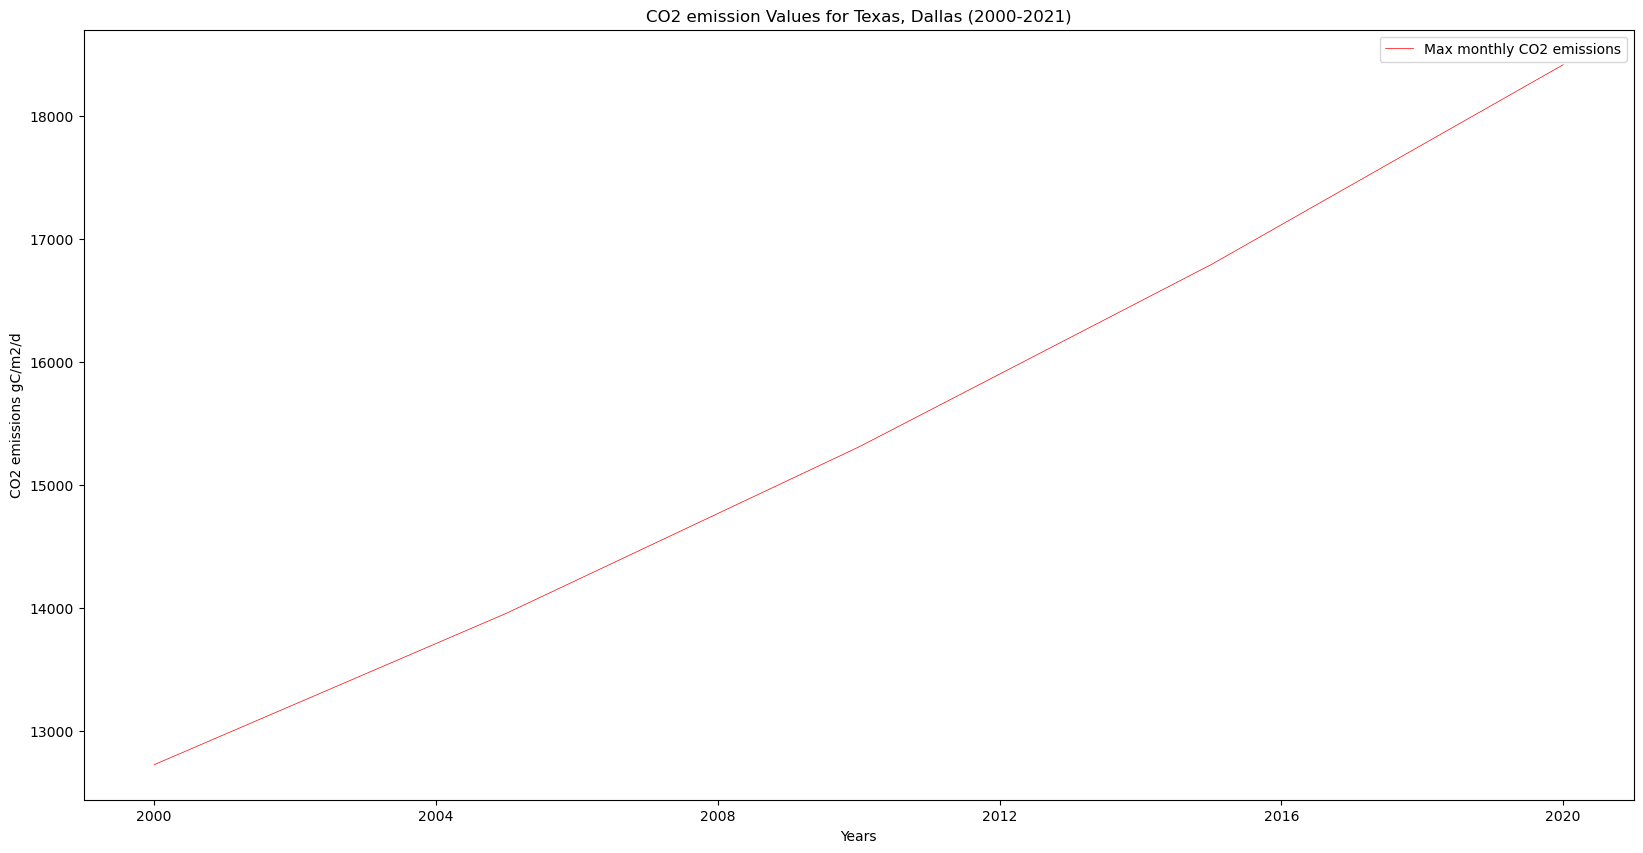

In [57]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 10))


plt.plot(
    df["date"],
    df["max"],
    color="red",
    linestyle="-",
    linewidth=0.5,
    label="Max monthly CO2 emissions",
)

plt.legend()
plt.xlabel("Years")
plt.ylabel("CO2 emissions gC/m2/d")
plt.title("CO2 emission Values for Texas, Dallas (2000-2021)")

In [58]:
print(items[2]["properties"]["start_datetime"])

2010-01-01T00:00:00+00:00


In [59]:
october_tile = requests.get(
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items[2]['collection']}&item={items[2]['id']}"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}",
).json()
october_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://2qncpyg24c.execute-api.us-west-2.amazonaws.com/api/raster/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=nasa-sedac-population-density&item=nasa-sedac-population-density-2010&assets=population-density&color_formula=gamma+r+1.05&colormap_name=rainbow&rescale=-1505.7174072265625%2C30795.859375'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 179.99999999999983, 89.99999999999991],
 'center': [-8.526512829121202e-14, -4.263256414560601e-14, 0]}

In [60]:
# Use bbox initial zoom and map
# Set up a map located w/in event bounds
import folium

aoi_map_bbox = Map(
    tiles="OpenStreetMap",
    location=[
        30,-100
    ],
    zoom_start=8,
)

map_layer = TileLayer(
    tiles=october_tile["tiles"][0],
    attr="GHG", opacity = 0.5
)

map_layer.add_to(aoi_map_bbox)

aoi_map_bbox

## Summary

In this notebook we have successfully explored, analysed and visualized STAC collecetion for ODIAC C02 fossisl fuel emission (2022).